In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('MLFlow BikeSharing Opt')
# mlflow.set_experiment('MLflow BikeSharing')

# Load the dataset
hourData = pd.read_csv('bike+sharing+dataset/hour.csv')


2025/05/09 12:34:52 INFO mlflow.tracking.fluent: Experiment with name 'MLFlow BikeSharing Opt' does not exist. Creating a new experiment.


In [60]:
def create_pipeline(estimator):
    numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
    categorical_features = ['season', 'mnth', 'hr', 'weekday', 'weathersit']

    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', estimator)
    ])

    return pipeline


In [61]:
X = hourData.drop(['instant', 'dteday', 'casual', 'registered', 'cnt'], axis=1)
y = hourData['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
def evaluate_model(estimator, name, params=None):
    pipeline = create_pipeline(estimator)

    # Use GridSearchCV only if parameters are provided
    if params:
        pipeline = GridSearchCV(
            pipeline,
            param_grid=params,
            cv=3,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

    with mlflow.start_run(run_name=name):
        pipeline.fit(X_train, y_train)
        y_preds = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        mae = mean_absolute_error(y_test, y_preds)
        r2 = r2_score(y_test, y_preds)

        mlflow.log_param("model", name)

        # Log best parameters from GridSearchCV, if available
        if params and hasattr(pipeline, "best_params_"):
            for param, value in pipeline.best_params_.items():
                mlflow.log_param(param, value)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"{name} -- RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))

        # Scatterplot
        sns.scatterplot(x=y_test, y=y_preds, ax=axes[0])
        axes[0].set_xlabel("True Values")
        axes[0].set_ylabel("Predicted Values")
        axes[0].set_title(f"{name}: True vs Predicted Values (Scatter)")

        # Add a reference line (y = x)
        min_val = min(y_test.min(), y_preds.min())
        max_val = max(y_test.max(), y_preds.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Perfect Prediction')
        axes[0].legend()

        # Lineplot
        step = 100
        sns.lineplot(x=range(0, len(y_test), step), y=y_test[::step], label="True Values", ax=axes[1], color='green')
        sns.lineplot(x=range(0, len(y_preds), step), y=y_preds[::step], label="Predicted Values", ax=axes[1], color='orange')
        axes[1].set_xlabel("Index")
        axes[1].set_ylabel("Values")
        axes[1].set_title(f"{name}: True vs Predicted Values (Line)")
        axes[1].legend()


2025/05/09 12:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Ridge -- RMSE: 108.67, MAE: 77.84, R2: 0.63
🏃 View run Ridge at: http://localhost:5000/#/experiments/938636931557433397/runs/157840964da14368a8727f32d00ee794
🧪 View experiment at: http://localhost:5000/#/experiments/938636931557433397


2025/05/09 12:34:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso -- RMSE: 108.59, MAE: 77.74, R2: 0.63
🏃 View run Lasso at: http://localhost:5000/#/experiments/938636931557433397/runs/5f1e2f5e91ef49adbb8a1f68d26bf6be
🧪 View experiment at: http://localhost:5000/#/experiments/938636931557433397
Fitting 3 folds for each of 12 candidates, totalling 36 fits


2025/05/09 12:36:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


TunedRandomForest -- RMSE: 73.35, MAE: 47.79, R2: 0.83
🏃 View run TunedRandomForest at: http://localhost:5000/#/experiments/938636931557433397/runs/0599e11d59284f3b9bf0b4a57fbbd722
🧪 View experiment at: http://localhost:5000/#/experiments/938636931557433397
Fitting 3 folds for each of 72 candidates, totalling 216 fits


2025/05/09 12:36:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


TunedXGBoost -- RMSE: 74.54, MAE: 52.03, R2: 0.82
🏃 View run TunedXGBoost at: http://localhost:5000/#/experiments/938636931557433397/runs/7b5170be07984b478d904aad083aeb33
🧪 View experiment at: http://localhost:5000/#/experiments/938636931557433397


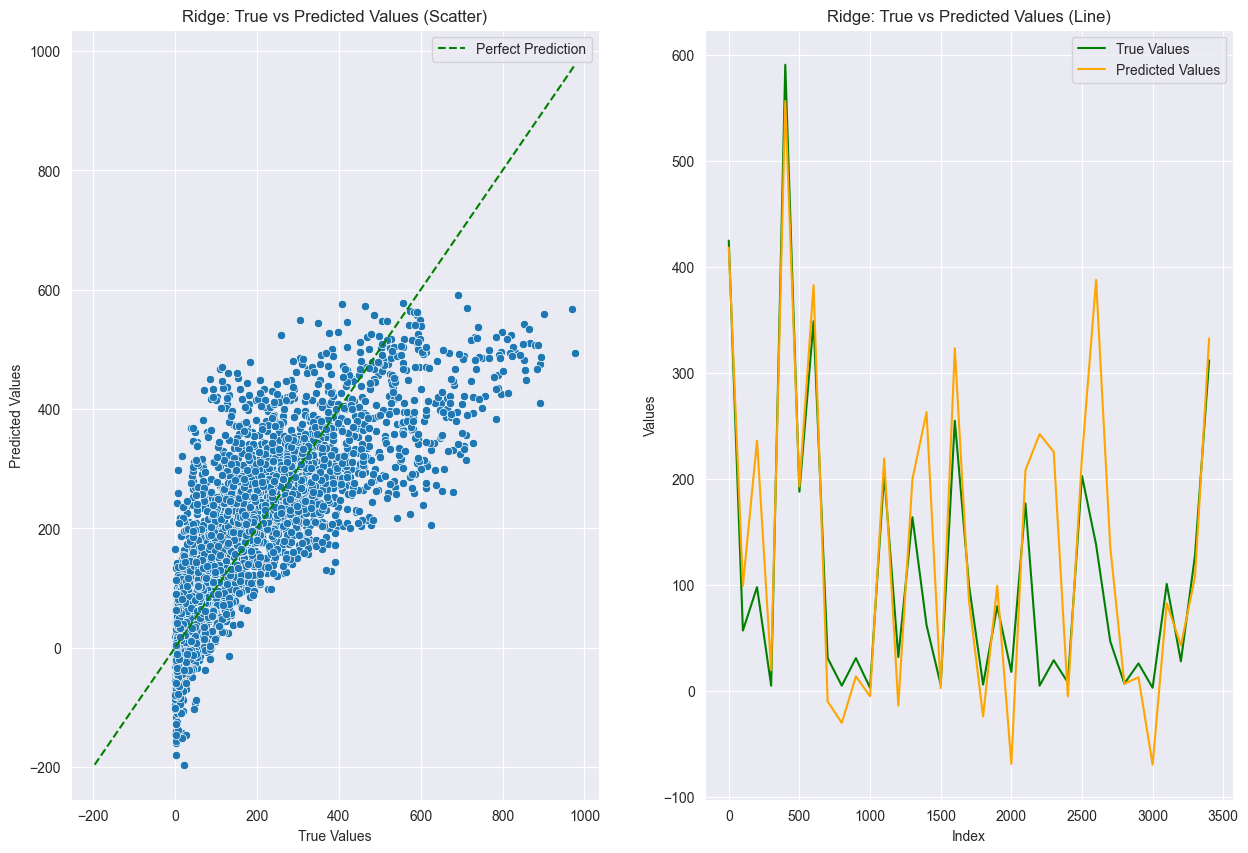

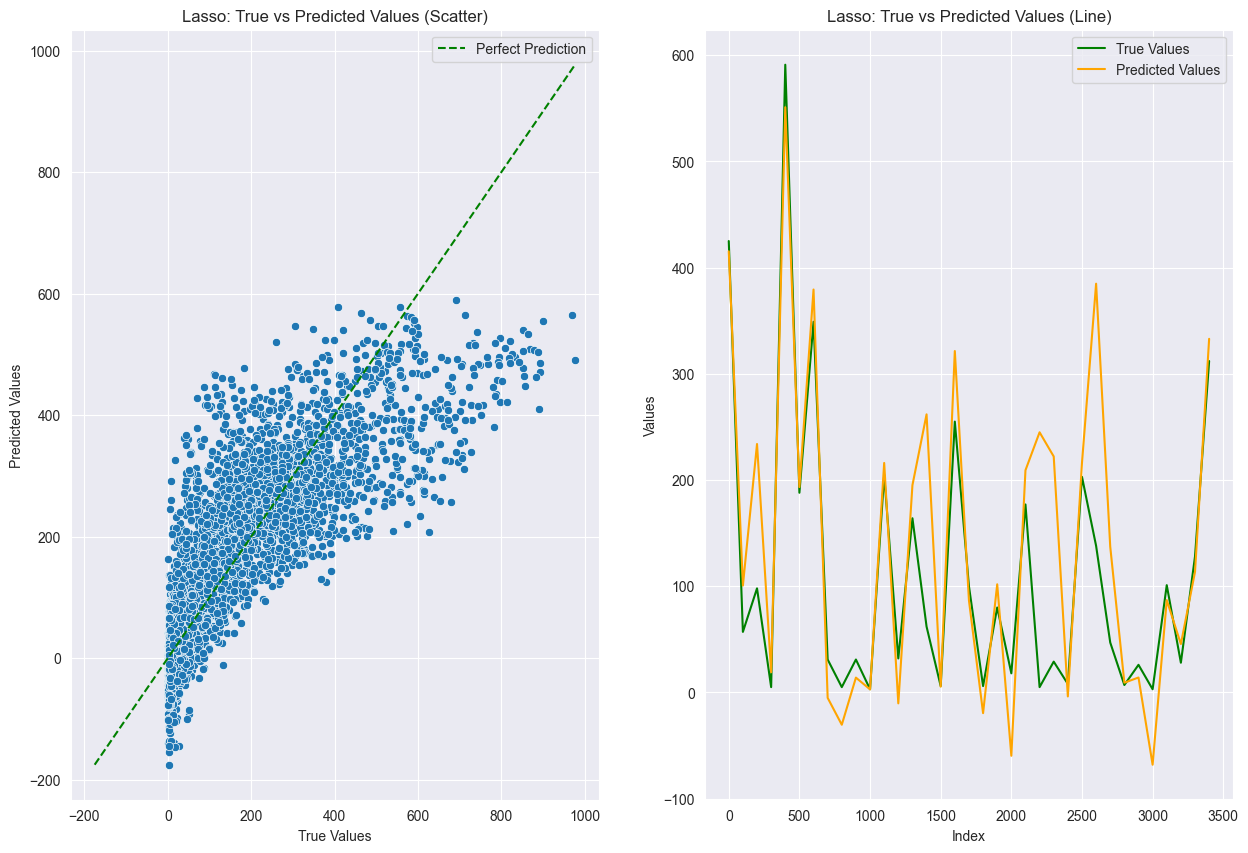

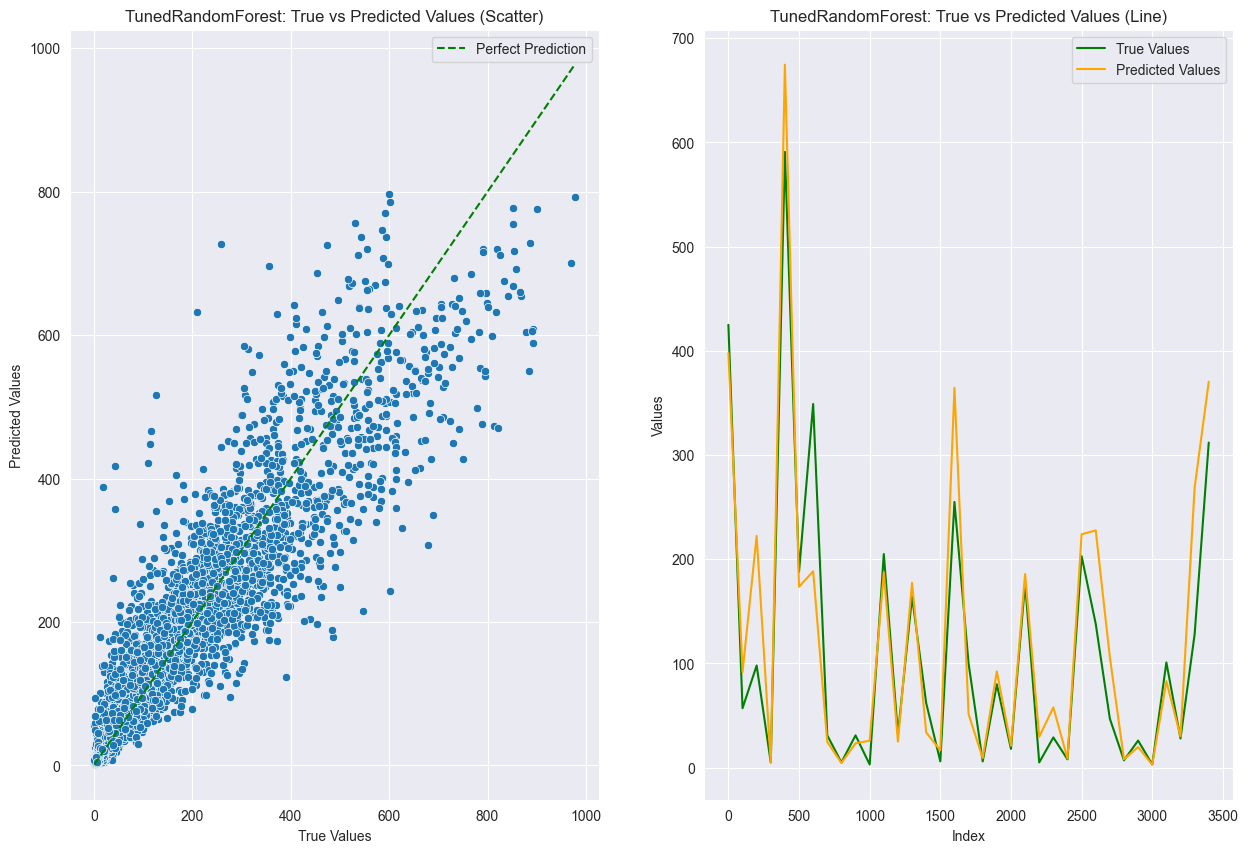

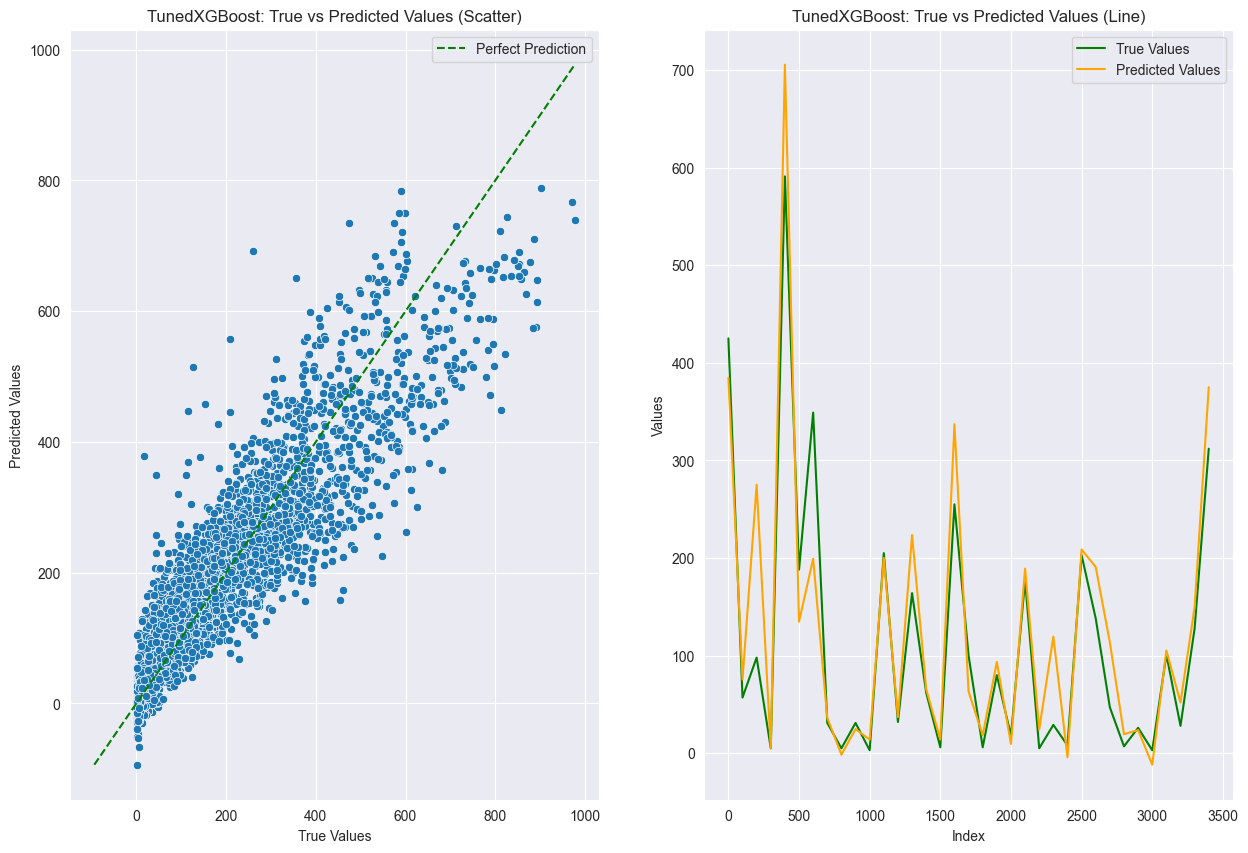

In [63]:
# Ridge Regression
evaluate_model(Ridge(alpha=0.1), "Ridge")

# Lasso Regression
evaluate_model(Lasso(alpha=0.1), "Lasso")

# Random Forest with Extended GridSearch
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}
evaluate_model(RandomForestRegressor(random_state=42), "TunedRandomForest", rf_params)

# XGBoost with Expanded GridSearch
xgb_params = {
    'regressor__n_estimators': [100, 150],
    'regressor__learning_rate': [0.05, 0.07, 0.1],
    'regressor__max_depth': [3, 4, 5],
    'regressor__subsample': [0.8, 1],
    'regressor__colsample_bytree': [0.8, 1]
}
evaluate_model(XGBRegressor(objective='reg:squarederror', random_state=42), "TunedXGBoost", xgb_params)


